In [16]:
"""Imports"""
import cv2
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from midi2audio import FluidSynth
from miditok import REMI, TokenizerConfig
from miditok.data_augmentation import augment_dataset
from miditok.utils import split_files_for_training
from pathlib import Path
from random import sample, seed as random_seed

In [17]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)

In [3]:
"""Train a tokenizer on each composer, split the data by number of tokens and augment the data"""
config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True, one_token_stream_for_programs=False)
tokenizer = REMI(config)

DATA_PATH = Path(Path.cwd().parent, "Data")
RETAIN = 100

for composer in ["Bach", "Beethoven", "Chopin", "Mozart"]:
	print(f"{composer}:")
	midi_path = list(Path(DATA_PATH, "Raw").glob(f"{composer}/*.mid"))
	tokenizer.train(vocab_size=500, files_paths=midi_path)
	subset_chunks_dir = Path(DATA_PATH, "Augmented", composer)
	
	split_files_for_training(
        files_paths=midi_path,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
		min_seq_len=1024
    )

	augment_dataset(
		subset_chunks_dir,
		pitch_offsets=[-6, 6],
		velocity_offsets=[-4, 4],
		duration_offsets=[-0.2, 0.2],
		save_data_aug_report=False,
	)

	# use RETAIN as upper bound of song count and remove excess at random to balance composer data
	all_files = list(Path(subset_chunks_dir).glob("*.mid"))
	composer_sample = sample(all_files, len(all_files) - RETAIN)
	for file_name in composer_sample:
		file_name.unlink()

Bach:





Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/Augmented/Bach): 100%|██████████| 10/10 [00:00<00:00, 140.98it/s]
Performing data augmentation: 100%|██████████| 108/108 [00:00<00:00, 1181.05it/s]


Beethoven:





Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/Augmented/Beethoven): 100%|██████████| 2/2 [00:00<00:00, 112.67it/s]
Performing data augmentation: 100%|██████████| 51/51 [00:00<00:00, 1095.92it/s]


Chopin:





Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/Augmented/Chopin): 100%|██████████| 1/1 [00:00<00:00, 148.08it/s]
Performing data augmentation: 100%|██████████| 15/15 [00:00<00:00, 872.63it/s]


Mozart:





Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/Augmented/Mozart): 100%|██████████| 2/2 [00:00<00:00, 198.27it/s]
Performing data augmentation: 100%|██████████| 21/21 [00:00<00:00, 988.59it/s]


In [ ]:
"""Convert midi file to spectrogram images and create mapping csv for classification"""
def scale_minmax(data, minimum, maximum):
    data_min, data_max = data.min(), data.max()
    std = (data - data_min) / (data_max - data_min)
    return std * (maximum - minimum) + minimum

def save_spectrogram_image(data, sampling_rate, out, hop_length, n_mels):
    mels = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # avoid log(0) error

    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)
    img = 255-img

    cv2.imwrite(out, img)
    
def get_composer_class(composer):
	if "Bach" in composer:
		return 0
	elif "Beethoven" in composer:
		return 1
	elif "Chopin" in composer:
		return 2
	elif "Mozart" in composer:
		return 3
	else:
		raise NameError

fluidsynth = FluidSynth()
DATA_PATH = Path(Path.cwd().parent, "Data")
spectrogram_midi_path = list(Path(DATA_PATH, "Augmented").glob(f"**/*.mid"))
spectrogram_path = Path(DATA_PATH, "Spectrogram")
labels = pd.DataFrame(columns=["filename", "class"])

for midi in spectrogram_midi_path:
	composer, filename = midi.parts[-2:]
	audio_filename = Path(spectrogram_path, filename.replace(".mid", ".flac"))
	output_filename = Path(spectrogram_path, filename.replace(".mid", ".png"))
	fluidsynth.midi_to_audio(midi, audio_filename)

	audio, fs = librosa.load(audio_filename, sr=None)
     
	time_steps = 384 # number of time-steps
	hop_length = 512 # Samples per time-step
	n_mels = 128 # Height of image
    
	save_spectrogram_image(audio[:time_steps*hop_length], sampling_rate=fs, out=output_filename, hop_length=hop_length, n_mels=n_mels)
	audio_filename.unlink()
	filename = output_filename.parts[-1]
	try:
		classification = get_composer_class(composer)
	except NameError:
		print(output_filename)
		
	labels.loc[len(labels)] = [filename, classification]

labels.to_csv(Path(DATA_PATH, "Spectrogram", "all.csv"))

fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/Spectrogram/0015_16#d96.flac'..


Show Progression of data from data prep steps above

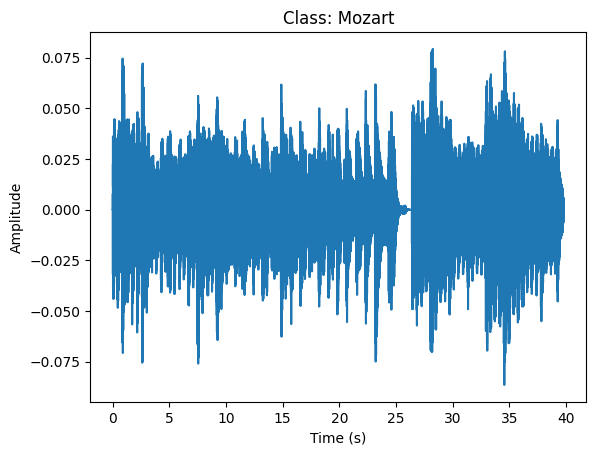

In [13]:
"""Audio wave after transformation from MIDI to flac"""
plt.figure()
plt.plot(np.arange(len(audio)) / fs, audio)
plt.title(f"Class: {composer}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

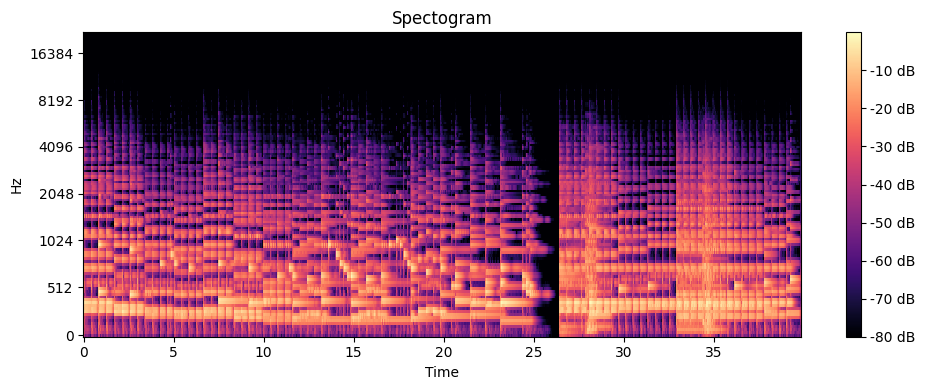

In [14]:
"""Mel-Spectrogram of audio wave"""
spectogram = librosa.feature.melspectrogram(y=audio, sr=fs)
spectogram_db = librosa.power_to_db(spectogram, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(spectogram_db, sr=fs, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectogram")
plt.tight_layout()
plt.show()

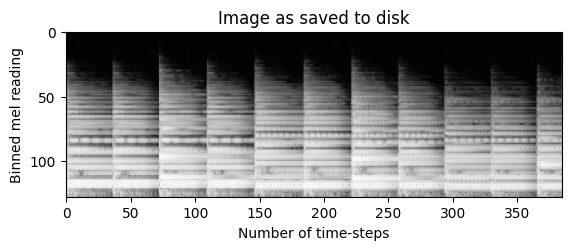

In [15]:
"""PNG of spectrogram as sampled in time series"""
saved_image = cv2.imread(output_filename, cv2.IMREAD_UNCHANGED)
plt.title("Image as saved to disk")
plt.ylabel("Binned mel reading")
plt.xlabel("Number of time-steps")
plt.imshow(saved_image, cmap="Greys")
plt.show()